<a href="https://colab.research.google.com/github/Matheusfrej/data-science-project/blob/main/Projeto%202/cars_prices_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importação das bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, mean_squared_error, roc_curve, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.naive_bayes import GaussianNB
from io import BytesIO
import matplotlib.image as mpimg

## Carregamento do dataset de carros já pré-processado

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cars = pd.read_excel('/content/drive/My Drive/Ciencia de dados individual/cars.xlsx')

cars

,year_of_reference,month_of_reference,brand,model,fuel,gear,engine_size,year_model,avg_price_brl,avg_price_brl_norm,avg_price_brl_interval,avg_price_brl_log,price_efficiency
0,2022.000000,10,31,2100,2,1,1.4,2011.000000,27685.000000,-0.290344,barato,4.442245,1.138832
1,2022.000000,7,6,282,2,1,1.8,2005.000000,24261.000000,-0.302188,barato,4.384909,1.082794
2,2022.000000,6,45,2391,2,0,2.0,2014.000000,147161.000000,0.122930,caro,5.167793,1.863733
3,2022.000000,6,19,1186,2,1,2.0,1997.000000,8483.000000,-0.356765,muito barato,3.928549,0.628171
4,2020.999894,3,-1,2588,2,1,4.0,2006.151683,319221.762376,0.718097,caro,5.504092,2.201729
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5892,2022.000000,4,76,951,2,1,1.0,2021.000000,181429.000000,0.241465,caro,5.258707,1.953140
5893,2022.000000,8,72,1626,1,1,2.8,2022.000000,214293.000000,0.355143,caro,5.331008,2.025227
5894,2021.000000,5,42,2788,1,1,2.0,2001.000000,23366.000000,-0.305284,barato,4.368584,1.067337
5895,2021.000000,6,73,2091,1,1,3.0,2006.000000,26525.000000,-0.294357,barato,4.423655,1.121324


## 1. Escolha de uma das colunas para classificação

In [ ]:
cars['avg_price_brl_interval']

0             barato
1             barato
2               caro
3       muito barato
4               caro
            ...     
5892            caro
5893            caro
5894          barato
5895          barato
5896          barato
Name: avg_price_brl_interval, Length: 5897, dtype: object

Mapeando esses valores categóricos para números

In [ ]:
price_interval_mapping = {
    "muito barato": 0,
    "barato": 1,
    "razoavel": 2,
    "caro": 3
}
cars['avg_price_brl_interval'] = cars['avg_price_brl_interval'].map(price_interval_mapping)

In [ ]:
cars['avg_price_brl_interval']

0       1
1       1
2       3
3       0
4       3
       ..
5892    3
5893    3
5894    1
5895    1
5896    1
Name: avg_price_brl_interval, Length: 5897, dtype: int64

Essas colunas são repetidas e representam a mesma coisa, por isso vou retirá-las. Além disso, eu quero que o modelo seja capaz de adivinhar o intervalo de preço do carro sem saber o preço do carro.

In [ ]:
cars = cars.drop(['avg_price_brl', 'avg_price_brl_norm',  'avg_price_brl_log', 'price_efficiency'], axis=1)

## 2. Separação dos dados em treinamento, validação e teste


In [ ]:
X = cars.drop('avg_price_brl_interval', axis=1)
y = cars['avg_price_brl_interval']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Normalização dos dados para melhor desempenho nos modelos

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train

array([[ 0.76463524,  0.16315312, -0.32616845, ...,  0.60295296,
        -0.23630259, -0.15102044],
       [ 0.76463524,  1.0534819 , -0.32616845, ...,  0.60295296,
        -0.84176663,  0.39174232],
       [ 0.76463524, -1.02395193, -0.32616845, ...,  0.60295296,
        -1.24540933,  0.17463722],
       ...,
       [ 0.76463524, -0.4303994 ,  0.24707318, ..., -1.65850419,
         0.77280416,  1.04305763],
       [-1.02694862,  0.75670564, -0.48995178, ...,  0.60295296,
        -0.43812394,  0.06608467],
       [-0.45197908,  1.35025816, -1.63643505, ...,  0.60295296,
         1.98373226,  0.33219793]])

## 3. Separar 4 algoritmos de acordo com a tarefa escolhida (classificação)

### Funções auxiliares

In [ ]:
def print_metrics(y_test, y_pred, y_pred_proba=[]):
  print(f"Acurácia: {accuracy_score(y_test, y_pred)}")
  print(f"Precisão: {precision_score(y_test, y_pred, average='macro')}")
  print(f"Recall: {recall_score(y_test, y_pred, average='macro')}")
  print()
  print(classification_report(y_test, y_pred))
  print()
  print("Erro quadrático médio: ", mean_squared_error(y_test, y_pred))
  if len(y_pred_proba):
    print("AUC da curva ROC:", roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))
  print()

In [ ]:
def plot_confusion_matrix(y_test, y_pred, labels):
  cm = confusion_matrix(y_test, y_pred, labels=labels)

  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)

  disp.plot()

  plt.show()

In [ ]:
def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names,
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)
    png_data = graph.create_png()
    img = mpimg.imread(BytesIO(png_data), format='png')

    plt.figure(figsize=(10, 10))
    plt.imshow(img, aspect='equal')
    plt.axis('off')
    plt.show()

### Algoritmo 1: MLP

Teste inicial do MLP

Instanciando o modelo com 1 camada oculta e 4 neurônios nela

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(4,))

In [ ]:
mlp.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(4,))

In [ ]:
predictions = mlp.predict(X_test)
predictions_proba = mlp.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.6897018970189702
Precisão: 0.6866993933738725
Recall: 0.6902253480348397

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       175
           1       0.61      0.61      0.61       186
           2       0.61      0.55      0.58       186
           3       0.77      0.82      0.79       191

    accuracy                           0.69       738
   macro avg       0.69      0.69      0.69       738
weighted avg       0.69      0.69      0.69       738


Erro quadrático médio:  0.4024390243902439
AUC da curva ROC: 0.9099250986618855



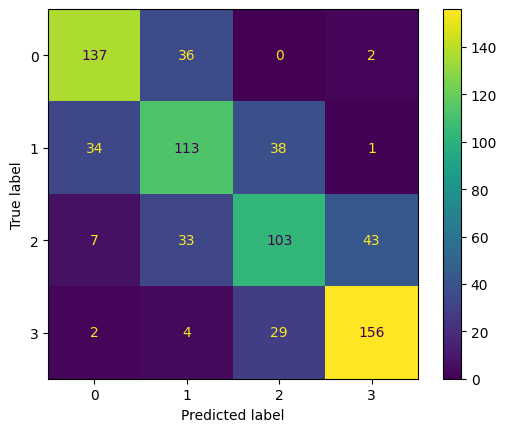

In [ ]:
plot_confusion_matrix(y_test, predictions, mlp.classes_)

### Algoritmo 2: Árvore de Decisão

Uma das vantagens da árvore de decisão é que ela é um modelo de caixa branca. Isso quer dizer que ela é auditável. É possível ver com facilidade que decisões ela tomou para decidir sobre uma classificação

In [ ]:
dt = DecisionTreeClassifier(random_state=42, max_depth=3)

In [ ]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [ ]:
predictions = dt.predict(X_test)
predictions_proba = dt.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.6409214092140921
Precisão: 0.6987882611260405
Recall: 0.645990944258129

              precision    recall  f1-score   support

           0       0.72      0.90      0.80       175
           1       0.60      0.47      0.53       186
           2       0.50      0.76      0.60       186
           3       0.98      0.45      0.62       191

    accuracy                           0.64       738
   macro avg       0.70      0.65      0.64       738
weighted avg       0.70      0.64      0.63       738


Erro quadrático médio:  0.470189701897019
AUC da curva ROC: 0.8635017496791149



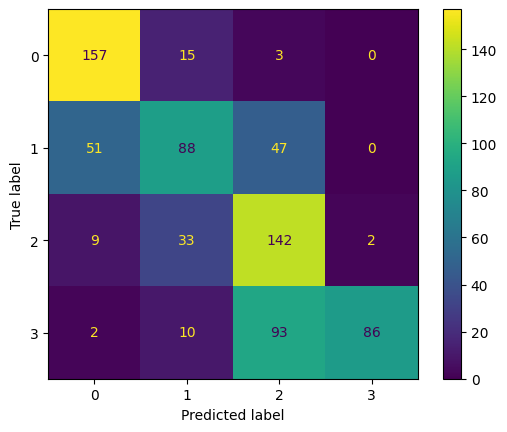

In [ ]:
plot_confusion_matrix(y_test, predictions, dt.classes_)

Podemos plotar como ficou o modelo da árvore de decisão.

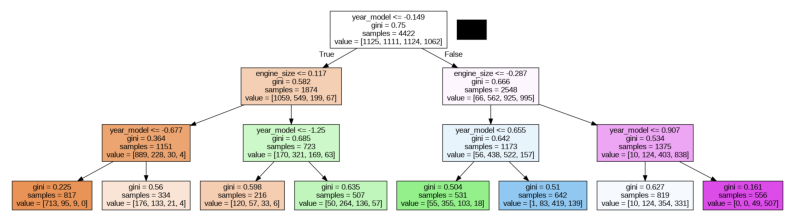

In [ ]:
tree_graph_to_png(dt, feature_names=X.columns,
                 png_file_to_save='dt.png')

### Algoritmo 3: Random Forest

Random forest é formado por várias decision trees, então o resultado dele vai ser melhor que da decision tree.

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
predictions = rf.predict(X_test)
predictions_proba = rf.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.8184281842818428
Precisão: 0.8167014066443
Precisão: 0.8183433059087508

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       175
           1       0.76      0.72      0.74       186
           2       0.78      0.78      0.78       186
           3       0.89      0.92      0.90       191

    accuracy                           0.82       738
   macro avg       0.82      0.82      0.82       738
weighted avg       0.82      0.82      0.82       738


Erro quadrático médio:  0.22493224932249323
AUC da curva ROC: 0.9578185215734271



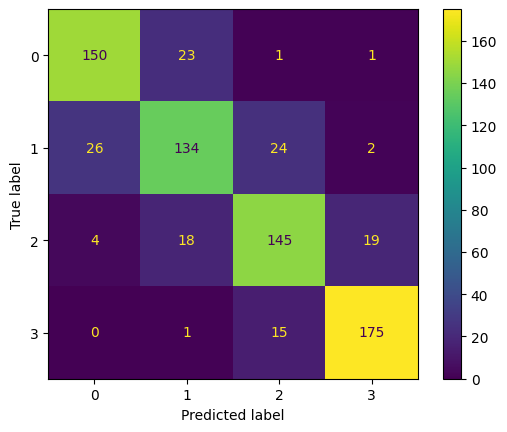

In [ ]:
plot_confusion_matrix(y_test, predictions, dt.classes_)

### Algoritmo 4: Naive Bayes

In [ ]:
nb = GaussianNB()

In [ ]:
nb.fit(X_train, y_train)

GaussianNB()

In [ ]:
predictions = nb.predict(X_test)
predictions_proba = nb.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.6111111111111112
Precisão: 0.61784687214215
Precisão: 0.6122749133431451

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       175
           1       0.54      0.50      0.52       186
           2       0.49      0.57      0.53       186
           3       0.75      0.66      0.70       191

    accuracy                           0.61       738
   macro avg       0.62      0.61      0.61       738
weighted avg       0.62      0.61      0.61       738


Erro quadrático médio:  0.5677506775067751
AUC da curva ROC: 0.847926678541336



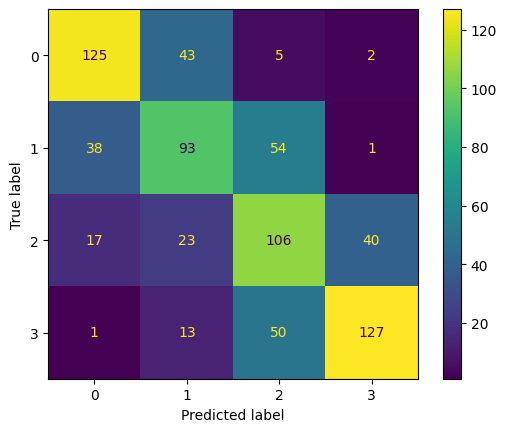

In [ ]:
plot_confusion_matrix(y_test, predictions, nb.classes_)

## 4. Adicionar MLFlow no treinamento dos modelos para rastreamento

### Realizando meus primeiros testes com o mlflow

In [ ]:
!pip install -q mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 63.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.6/147.6 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 7.4 MB/s eta 0:00:00


In [ ]:
import mlflow
import mlflow.sklearn
import logging
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from urllib.parse import urlparse

In [ ]:
logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [ ]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    ac = accuracy_score(y_test, pred)
    ps = precision_score(y_test, pred, average='macro')
    rc = recall_score(y_test, pred, average='macro')
    return rmse, mae, r2, ac, ps, rc

Essa função será chamada para registrar o novo modelo treinado no MLFlow

In [ ]:
def save_model_in_mlflow(model, y_pred, model_name):
  with mlflow.start_run():
    (rmse, mae, r2, ac, ps, rc) = eval_metrics(y_test, y_pred)

    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("acc", ac)
    mlflow.log_metric("precision", ps)
    mlflow.log_metric("recall", rc)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    mlflow.sklearn.log_model(model, "model", registered_model_name=model_name)

### Para visualizar o MLFlow

In [ ]:
!pip install -q pyngrok

In [ ]:
from pyngrok import ngrok

ngrok.kill()

NGROK_AUTH_TOKEN = "2gekSDgtME86uy3zZrLfLku5a5L_7pgaLWcTj2in6VWmR7tjH"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://08ba-34-106-234-27.ngrok-free.app


In [ ]:
!mlflow ui

[2024-05-19 17:50:48 +0000] [11978] [INFO] Starting gunicorn 22.0.0
[2024-05-19 17:50:48 +0000] [11978] [INFO] Listening at: http://127.0.0.1:5000 (11978)
[2024-05-19 17:50:48 +0000] [11978] [INFO] Using worker: sync
[2024-05-19 17:50:48 +0000] [11979] [INFO] Booting worker with pid: 11979
[2024-05-19 17:50:48 +0000] [11980] [INFO] Booting worker with pid: 11980
[2024-05-19 17:50:48 +0000] [11981] [INFO] Booting worker with pid: 11981
[2024-05-19 17:50:48 +0000] [11982] [INFO] Booting worker with pid: 11982
[2024-05-19 17:51:09 +0000] [11978] [INFO] Handling signal: int

Aborted!
[2024-05-19 17:51:10 +0000] [11979] [INFO] Worker exiting (pid: 11979)
[2024-05-19 17:51:10 +0000] [11980] [INFO] Worker exiting (pid: 11980)
[2024-05-19 17:51:10 +0000] [11981] [INFO] Worker exiting (pid: 11981)
[2024-05-19 17:51:10 +0000] [11982] [INFO] Worker exiting (pid: 11982)
[2024-05-19 17:51:11 +0000] [11978] [INFO] Shutting down: Master


## 5. Executar uma ferramenta de seleção de hiper-parâmetros sobre o conjunto de validação

Existem várias ferramentas para escolha de hiper-parâmetros, como grid search e optuna.

Vou optar pelo Optuna, pois ele faz uma seleção mais inteligente do que o grid search, que é mais força bruta.

In [ ]:
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
import optuna

### Escolha de parâmetros para o MLP

Utilizando os dados de validação para fazer essa escolha de parâmetros.

Parametros a serem escolhidos:
- solver
- activation
- learning_rate

In [ ]:
def objective(trial):
    solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
    activation = trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu'])
    learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])

    mlp = MLPClassifier(random_state=42,
                        max_iter=10000,
                        solver=solver,
                        activation=activation,
                        learning_rate=learning_rate).fit(X_train, y_train)

    predictions = mlp.predict(X_val)
    acc = accuracy_score(y_val, predictions)

    return acc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-05-18 23:38:59,275] A new study created in memory with name: no-name-6f14b1bb-4fab-4e73-9427-c9b98fc6549b
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2024-05-18 23:39:45,441] Trial 0 finished with value: 0.7544097693351425 and parameters: {'solver': 'adam', 'activation': 'tanh', 'learning_rate': 'invscaling'}. Best is trial 0 with value: 0.7544097693351425.
[I 2024-05-18 23:39:47,801] Trial 1 finished with value: 0.6811397557666214 and parameters: {'solver': 'sgd', 'activation': 'identity', 'learning_rate': 'adaptive'}. Best is trial 0 with value: 0.7544097693351425.
[I 2024-05-18 23:40:00,246] Trial 2 finished with value: 0.7557666214382632 and parameters: {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'adaptive'}. Best is trial 2 with value: 0.7557666214382632.
[I 2024-05-18 23:40:12,555] Trial 3 finished with value: 0.755

In [ ]:
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor valor de acurácia: {study.best_value}")

Melhores hiperparâmetros: {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'adaptive'}
Melhor valor de função de perda: 0.7557666214382632


Melhores hiperparâmetros: {'solver': 'adam', 'activation': 'relu', 'learning_rate': 'adaptive'}
Melhor valor de função de perda: 0.7557666214382632

Agora com os melhores hiper-parametros, posso rodar o modelo do MLP

In [ ]:
mlp = MLPClassifier(random_state=42,
                        max_iter=10000,
                        solver='adam',
                        activation='relu',
                        learning_rate='adaptive').fit(X_train, y_train)

predictions = mlp.predict(X_test)
predictions_proba = mlp.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.7642276422764228
Precisão: 0.7612099881712214
Recall: 0.7651499907512406

              precision    recall  f1-score   support

           0       0.80      0.87      0.84       175
           1       0.75      0.68      0.71       186
           2       0.69      0.64      0.66       186
           3       0.80      0.87      0.83       191

    accuracy                           0.76       738
   macro avg       0.76      0.77      0.76       738
weighted avg       0.76      0.76      0.76       738


Erro quadrático médio:  0.33875338753387535
AUC da curva ROC: 0.9387115443909748



Salvando no mlflow

In [ ]:
save_model_in_mlflow(mlp, predictions, "MLP")

Registered model 'MLP' already exists. Creating a new version of this model...
Created version '6' of model 'MLP'.


Vou tentar novamente o MLP, mas aumentando o número de neurônios e de camadas para ver se tem alguma diferença

In [ ]:
mlp = MLPClassifier(random_state=42,
                        max_iter=10000,
                        hidden_layer_sizes=(256, 128, 64),
                        solver='adam',
                        activation='relu',
                        learning_rate='adaptive').fit(X_train, y_train)

predictions = mlp.predict(X_test)
predictions_proba = mlp.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.7628726287262872
Precisão: 0.7600203742516344
Recall: 0.7637917903185594

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       175
           1       0.71      0.68      0.70       186
           2       0.71      0.65      0.67       186
           3       0.81      0.86      0.83       191

    accuracy                           0.76       738
   macro avg       0.76      0.76      0.76       738
weighted avg       0.76      0.76      0.76       738


Erro quadrático médio:  0.33062330623306235
AUC da curva ROC: 0.9322305493239573



In [ ]:
save_model_in_mlflow(mlp, predictions, "MLP")

Registered model 'MLP' already exists. Creating a new version of this model...
Created version '7' of model 'MLP'.


A acurácia não mudou muito, mesmo adicionando mais neurônios e camadas, então o modelo não parece evoluir muito mais que isso

### Escolha de parâmetros para a Árvore de Decisão

Parametros a serem escolhidos:
- criterion
- splitter

In [ ]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    splitter = trial.suggest_categorical('splitter', ['best', 'random'])

    dt = DecisionTreeClassifier(random_state=42,
                        criterion=criterion,
                        splitter=splitter).fit(X_train, y_train)

    predictions = dt.predict(X_val)
    acc = accuracy_score(y_val, predictions)

    return acc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-05-19 00:15:14,719] A new study created in memory with name: no-name-48f58daa-0866-4a47-9962-502c4c5b6aa8
[I 2024-05-19 00:15:14,756] Trial 0 finished with value: 0.7449118046132972 and parameters: {'criterion': 'log_loss', 'splitter': 'best'}. Best is trial 0 with value: 0.7449118046132972.
[I 2024-05-19 00:15:14,783] Trial 1 finished with value: 0.7313432835820896 and parameters: {'criterion': 'gini', 'splitter': 'best'}. Best is trial 0 with value: 0.7449118046132972.
[I 2024-05-19 00:15:14,817] Trial 2 finished with value: 0.7449118046132972 and parameters: {'criterion': 'log_loss', 'splitter': 'best'}. Best is trial 0 with value: 0.7449118046132972.
[I 2024-05-19 00:15:14,844] Trial 3 finished with value: 0.7313432835820896 and parameters: {'criterion': 'gini', 'splitter': 'best'}. Best is trial 0 with value: 0.7449118046132972.
[I 2024-05-19 00:15:14,861] Trial 4 finished with value: 0.7367706919945726 and parameters: {'criterion': 'log_loss', 'splitter': 'random'}. Best 

In [ ]:
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor valor de acurácia: {study.best_value}")

Melhores hiperparâmetros: {'criterion': 'log_loss', 'splitter': 'best'}
Melhor valor de função de perda: 0.7449118046132972


Melhores hiperparâmetros: {'criterion': 'log_loss', 'splitter': 'best'}
Melhor valor de função de perda: 0.7449118046132972

Rodando a DecisionTree para os melhores parâmetros e para o conjunto de teste

In [ ]:
dt = DecisionTreeClassifier(random_state=42,
                        criterion='log_loss',
                        splitter='best').fit(X_train, y_train)

predictions = dt.predict(X_test)
predictions_proba = dt.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.7479674796747967
Precisão: 0.7465775743942297
Recall: 0.748844829943462

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       175
           1       0.72      0.67      0.69       186
           2       0.66      0.65      0.65       186
           3       0.80      0.83      0.82       191

    accuracy                           0.75       738
   macro avg       0.75      0.75      0.75       738
weighted avg       0.75      0.75      0.75       738


Erro quadrático médio:  0.33604336043360433
AUC da curva ROC: 0.8323704828359613



Salvando modelo no MLflow

In [ ]:
save_model_in_mlflow(dt, predictions, "DecisionTree")

Registered model 'DecisionTree' already exists. Creating a new version of this model...
Created version '1' of model 'DecisionTree'.


### Escolha de parâmetros para a Random Forest

Parametros a serem escolhidos:
- n_estimators
- max_depth
- min_samples_split

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    rf = RandomForestClassifier(random_state=42,
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split).fit(X_train, y_train)

    predictions = rf.predict(X_val)
    acc = accuracy_score(y_val, predictions)

    return acc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-05-19 00:32:22,128] A new study created in memory with name: no-name-6e410199-eb7c-45ec-b62a-1d970cd361bb
[I 2024-05-19 00:32:30,262] Trial 0 finished with value: 0.8046132971506106 and parameters: {'n_estimators': 315, 'max_depth': 21, 'min_samples_split': 4}. Best is trial 0 with value: 0.8046132971506106.
[I 2024-05-19 00:32:33,142] Trial 1 finished with value: 0.7951153324287653 and parameters: {'n_estimators': 251, 'max_depth': 43, 'min_samples_split': 8}. Best is trial 0 with value: 0.8046132971506106.
[I 2024-05-19 00:32:35,488] Trial 2 finished with value: 0.7896879240162822 and parameters: {'n_estimators': 459, 'max_depth': 33, 'min_samples_split': 10}. Best is trial 0 with value: 0.8046132971506106.
[I 2024-05-19 00:32:37,656] Trial 3 finished with value: 0.8086838534599728 and parameters: {'n_estimators': 372, 'max_depth': 23, 'min_samples_split': 2}. Best is trial 3 with value: 0.8086838534599728.
[I 2024-05-19 00:32:39,825] Trial 4 finished with value: 0.8059701492

In [ ]:
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor valor de acurácia: {study.best_value}")

Melhores hiperparâmetros: {'n_estimators': 372, 'max_depth': 23, 'min_samples_split': 2}
Melhor valor de acurácia: 0.8086838534599728


Melhores hiperparâmetros: {'n_estimators': 372, 'max_depth': 23, 'min_samples_split': 2}
Melhor valor de função de perda: 0.8086838534599728

Rodando a RandomForest para os melhores parâmetros e para o conjunto de teste

In [ ]:
rf = RandomForestClassifier(random_state=42,
                        n_estimators=372,
                        max_depth=23,
                        min_samples_split=2).fit(X_train, y_train)

predictions = rf.predict(X_test)
predictions_proba = rf.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.8224932249322493
Precisão: 0.8212279282358441
Recall: 0.8224952348782781

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       175
           1       0.77      0.74      0.75       186
           2       0.78      0.78      0.78       186
           3       0.89      0.91      0.90       191

    accuracy                           0.82       738
   macro avg       0.82      0.82      0.82       738
weighted avg       0.82      0.82      0.82       738


Erro quadrático médio:  0.2140921409214092
AUC da curva ROC: 0.9590307819848989



Salvando no MLflow

In [ ]:
save_model_in_mlflow(rf, predictions, "RandomForest")

Registered model 'RandomForest' already exists. Creating a new version of this model...
Created version '1' of model 'RandomForest'.


### Escolha de parâmetros para o Naive Bayes



Parametros a serem escolhidos:
- var_smoothing

In [ ]:
def objective(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-9, 1e0, log=True)

    nb = GaussianNB(var_smoothing=var_smoothing).fit(X_train, y_train)

    predictions = nb.predict(X_val)
    acc = accuracy_score(y_val, predictions)

    return acc

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2024-05-19 00:44:11,542] A new study created in memory with name: no-name-a4ae0de1-0eff-4305-9bb8-5b297831f143
[I 2024-05-19 00:44:11,554] Trial 0 finished with value: 0.576662143826323 and parameters: {'var_smoothing': 0.0025790091445004834}. Best is trial 0 with value: 0.576662143826323.
[I 2024-05-19 00:44:11,563] Trial 1 finished with value: 0.576662143826323 and parameters: {'var_smoothing': 2.7920089404836758e-05}. Best is trial 0 with value: 0.576662143826323.
[I 2024-05-19 00:44:11,572] Trial 2 finished with value: 0.576662143826323 and parameters: {'var_smoothing': 0.002171519121126321}. Best is trial 0 with value: 0.576662143826323.
[I 2024-05-19 00:44:11,583] Trial 3 finished with value: 0.5793758480325645 and parameters: {'var_smoothing': 0.015411314303305583}. Best is trial 3 with value: 0.5793758480325645.
[I 2024-05-19 00:44:11,596] Trial 4 finished with value: 0.576662143826323 and parameters: {'var_smoothing': 1.2255019641262299e-07}. Best is trial 3 with value: 0.5

In [ ]:
print(f"Melhores hiperparâmetros: {study.best_params}")
print(f"Melhor valor de acurácia: {study.best_value}")

Melhores hiperparâmetros: {'var_smoothing': 0.6221160696147329}
Melhor valor de acurácia: 0.5861601085481682


Melhores hiperparâmetros: {'var_smoothing': 0.6221160696147329}
Melhor valor de acurácia: 0.5861601085481682

Pela métrica da acurácia, o Naive Bayes teve o pior desempenho entre os modelos escolhidos
Irei rodar ele com os melhores parametros para o conjunto de teste

In [ ]:
nb = GaussianNB(var_smoothing=0.6221160696147329).fit(X_train, y_train)

predictions = nb.predict(X_test)
predictions_proba = nb.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.6124661246612466
Precisão: 0.635874300543431
Recall: 0.614660650951818

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       175
           1       0.52      0.56      0.54       186
           2       0.51      0.60      0.55       186
           3       0.83      0.56      0.67       191

    accuracy                           0.61       738
   macro avg       0.64      0.61      0.62       738
weighted avg       0.64      0.61      0.62       738


Erro quadrático médio:  0.5975609756097561
AUC da curva ROC: 0.8417552349136237



In [ ]:
save_model_in_mlflow(nb, predictions, "NaiveBayes")

Registered model 'NaiveBayes' already exists. Creating a new version of this model...
Created version '1' of model 'NaiveBayes'.


### Selecionando o melhor modelo geral de acordo com a métrica de avaliação definida

### A partir da análise no MLflow, o modelo de **Random Forest** se saiu melhor em todas as métricas avaliadas. São elas acurácia, r2 score, rmse, mean absolute error, precision e recall.

Vou deixar alguns exemplos de gráficos. O random forest é representado pelo **agreeable-elk-850**

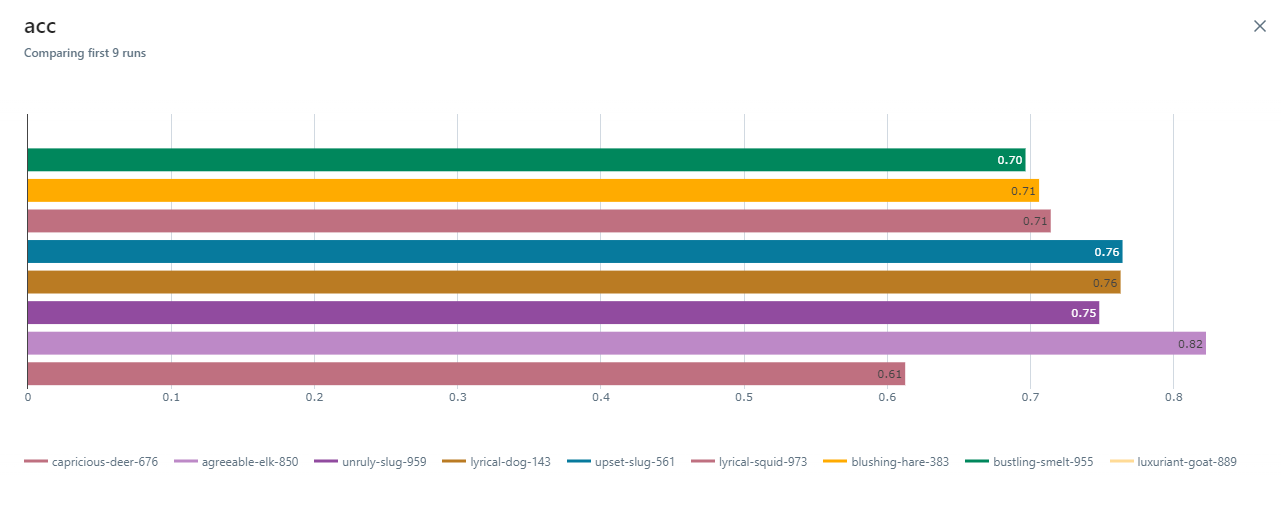

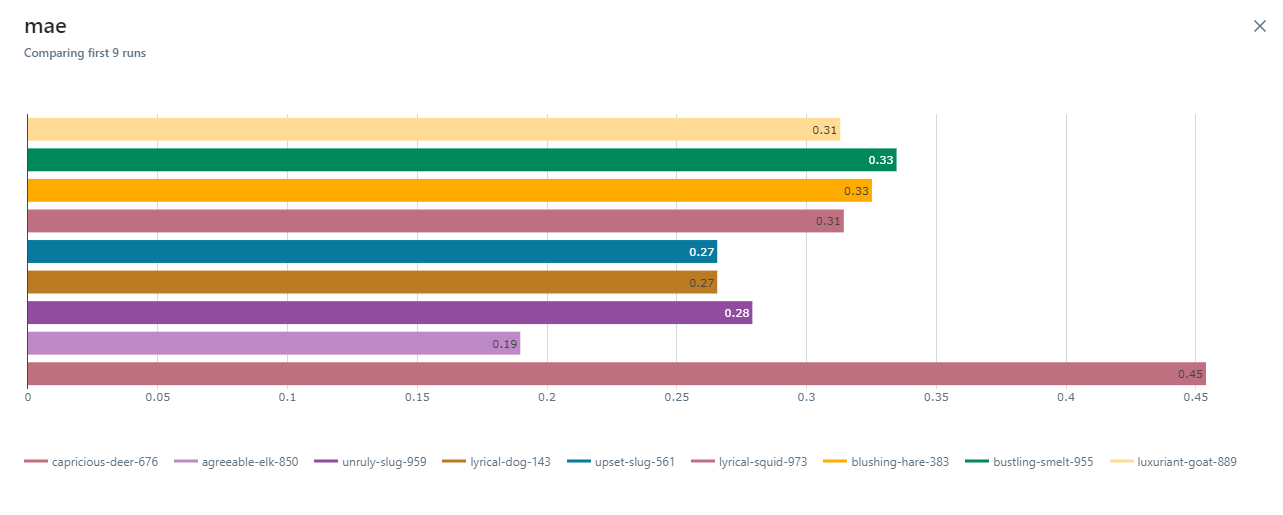

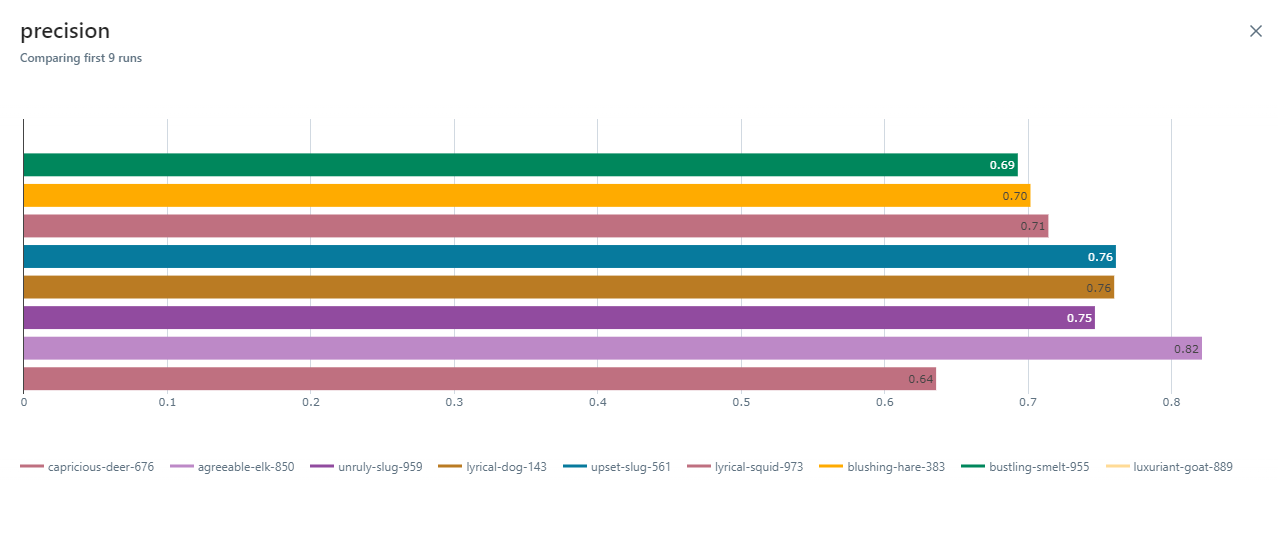

## 6. Realizar diagnóstico do melhor modelo geral da etapa 5 e melhorá-lo a partir do diagnóstico.

O modelo random forest foi o melhor modelo encontrado até o momento.
Irei fazer algumas análises para entender o que é possível melhorar dele.

In [ ]:
rf = RandomForestClassifier(random_state=42,
                        n_estimators=372,
                        max_depth=23,
                        min_samples_split=2).fit(X_train, y_train)

In [ ]:
predictions = rf.predict(X_test)
predictions_proba = rf.predict_proba(X_test)

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.8224932249322493
Precisão: 0.8212279282358441
Recall: 0.8224952348782781

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       175
           1       0.77      0.74      0.75       186
           2       0.78      0.78      0.78       186
           3       0.89      0.91      0.90       191

    accuracy                           0.82       738
   macro avg       0.82      0.82      0.82       738
weighted avg       0.82      0.82      0.82       738


Erro quadrático médio:  0.2140921409214092
AUC da curva ROC: 0.9590307819848989



Hiper-parâmetros do modelo

In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 23,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 372,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Importância de cada feature (coluna) para o modelo. É possível ter alguns insights interessantes a partir disso

In [ ]:
rf.feature_importances_

array([0.04354118, 0.07469269, 0.11589042, 0.15931267, 0.02842189,
       0.03083501, 0.16326235, 0.3840438 ])

In [ ]:
X.head()

,year_of_reference,month_of_reference,brand,model,fuel,gear,engine_size,year_model
0,2022.000000,10,31,2100,2,1,1.4,2011.000000
1,2022.000000,7,6,282,2,1,1.8,2005.000000
2,2022.000000,6,45,2391,2,0,2.0,2014.000000
3,2022.000000,6,19,1186,2,1,2.0,1997.000000
4,2020.999894,3,-1,2588,2,1,4.0,2006.151683


### Feature engineering: tentativa de One-hot-encoding na coluna de brand (marca) do carro para melhorar a performance do modelo

In [ ]:
new_X = pd.get_dummies(X, columns=['brand'], dtype='int64')

new_X.head()

,year_of_reference,month_of_reference,model,fuel,gear,engine_size,year_model,brand_-1,brand_0,brand_1,...,brand_69,brand_70,brand_71,brand_72,brand_73,brand_74,brand_75,brand_76,brand_77,brand_78
0,2022.000000,10,2100,2,1,1.4,2011.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2022.000000,7,282,2,1,1.8,2005.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2022.000000,6,2391,2,0,2.0,2014.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2022.000000,6,1186,2,1,2.0,1997.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020.999894,3,2588,2,1,4.0,2006.151683,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(new_X, y, test_size=0.25, random_state=42)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_lime = X_train
X_test_lime = X_test
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
rf = RandomForestClassifier(random_state=42,
                        n_estimators=372,
                        max_depth=23,
                        min_samples_split=2).fit(X_train, y_train)

In [ ]:
predictions = rf.predict(X_test)
predictions_proba = rf.predict_proba(X_test)

Como pode ser observado abaixo, houve uma pequena melhora nas métricas do modelo a partir da aplicação do one-hot-encoding!

In [ ]:
print_metrics(y_test, predictions, predictions_proba)

Acurácia: 0.8292682926829268
Precisão: 0.8274666317309702
Recall: 0.8290749229940245

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       175
           1       0.77      0.74      0.76       186
           2       0.81      0.78      0.79       186
           3       0.89      0.93      0.91       191

    accuracy                           0.83       738
   macro avg       0.83      0.83      0.83       738
weighted avg       0.83      0.83      0.83       738


Erro quadrático médio:  0.2073170731707317
AUC da curva ROC: 0.9594262428054663



In [ ]:
save_model_in_mlflow(rf, predictions, "RandomForest")

/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'RandomForest'.
Created version '1' of model 'RandomForest'.


### Técnicas de Explainable AI para entender melhor o modelo

Permutation Feature Importance

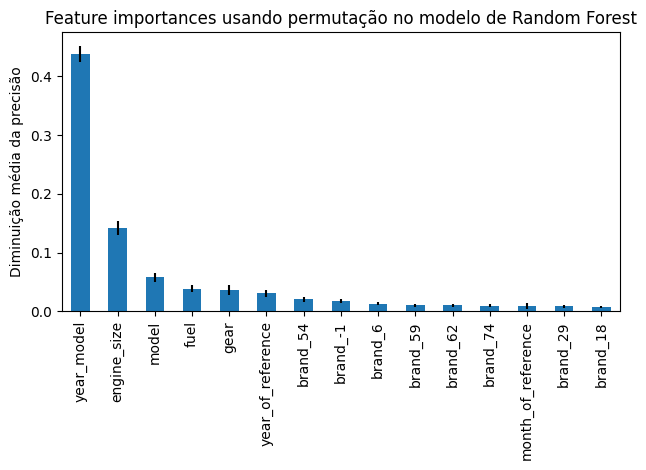

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result_rf = permutation_importance(rf, X_test, y_test, n_repeats=30, random_state=42)

forest_importances = pd.Series(result_rf.importances_mean, index=new_X.columns)
forest_importances_std = pd.Series(result_rf.importances_std, index=new_X.columns)

top_15_features = forest_importances.nlargest(15)
top_15_std = forest_importances_std[top_15_features.index]

fig, ax = plt.subplots()
top_15_features.plot.bar(yerr=top_15_std, ax=ax)

ax.set_title("Feature importances usando permutação no modelo de Random Forest")
ax.set_ylabel("Diminuição média da precisão")
fig.tight_layout()
plt.show()

### Lime

O LIME serve para dar uma explicação em uma predição de um exemplo individual. Ele vê quais foram as features mais relevantes para tomar uma decisão sobre esse caso específico.

In [ ]:
!pip install -q lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from lime import lime_tabular

# Criando o explicador
explainer = lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names= X_train_lime.columns,
                                                   discretize_continuous=False)

In [ ]:
from random import randint

i = randint(0, X_test_lime.shape[0] - 1)

random_instance = X_test_lime.iloc[i, :]
true_label = y_test.iloc[i]

# Obter a classe predita
predicted_label = rf.predict(X_test[i].reshape(1, -1))[0]

print("Instância sorteada:")
print(random_instance)
print("Classe real:", true_label)
print("Classe predita:", predicted_label)

exp = explainer.explain_instance(X_test[i], rf.predict_proba, num_features= 3, labels = [0,1,2,3])

exp.show_in_notebook(show_table=True, show_all=False)

Instância sorteada:
year_of_reference     2021.0
month_of_reference       4.0
model                 2960.0
fuel                     2.0
gear                     1.0
                       ...  
brand_74                 0.0
brand_75                 0.0
brand_76                 0.0
brand_77                 0.0
brand_78                 0.0
Name: 3803, Length: 85, dtype: float64
Classe real: 3
Classe predita: 3
